# Training Deep Learning in Tomato Classification
Krish Naik

In [1]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
!kaggle datasets download -d noulam/tomato

100% 743M/743M [00:04<00:00, 186MB/s]



In [3]:
!unzip tomato

Streaming output truncated to the last 5000 lines.
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/train/Tomato___healthy/ac022a2b-764c-4507-8dd9-4470b75763e4___RS_HL 9937.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/train/Tomato___healthy/ac249839-fe21-45cd-9e09-f0023fa7ee3a___GH_HL Leaf 273.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/train/Tomato___healthy/acdbf632-8d26-472d-874f-6d7df5cd0432___RS_HL 9897.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/train/Tomato___healthy/acdf2283-0e7c-4ccd-8817-1019e3a8ed20___RS_HL 9943.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/train/Tomato___healthy/acf28842-7821-4f31-ab73-2787e332e852___RS_HL 0011.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/train/Tomato___h

In [4]:
!nvidia-smi

Tue Nov  2 20:39:16 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
!pip install tensorflow==2.3.0

In [2]:
import tensorflow as tf
tf.__version__

'2.3.0'

In [3]:
!rm -rf "new plant diseases dataset(augmented)"

In [4]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

## Import Libraries

In [5]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten 
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
# from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import preprocess_input 
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential 
import numpy as np
from glob import glob

## Resizing Images

In [6]:
IMAGE_SIZE = [224, 224]

train_path = 'data/train'
test_path = 'data/valid'

In [7]:
# Import Inception V3 library as shown below and add preprocessing layer to the front of Inception V3
# Here we will be using imagenet .weights

inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', 
                        include_top=False)

87916544/87910968 [==============================] - 2s 0us/step


In [8]:
# Don't train existing weights
for layer in inception.layers:
  layer.trainable = False 

In [9]:
# Useful for getting number of output classes
folders = glob(train_path + '/*')

In [10]:
folders

['data/train/Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'data/train/Tomato___Spider_mites Two-spotted_spider_mite',
 'data/train/Tomato___Target_Spot',
 'data/train/Tomato___Late_blight',
 'data/train/Tomato___healthy',
 'data/train/Tomato___Tomato_mosaic_virus',
 'data/train/Tomato___Leaf_Mold',
 'data/train/Tomato___Bacterial_spot',
 'data/train/Tomato___Septoria_leaf_spot',
 'data/train/Tomato___Early_blight']

In [11]:
# Our layers - You can add more if you want
x = Flatten()(inception.output)

In [12]:
prediction = Dense(len(folders), activation='softmax')(x)

In [13]:
# Create a model object
model = Model(inputs=inception.input, outputs=prediction)

In [14]:
# View the structure of the model
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

## Tell model about cost and optimization method to use

In [15]:
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [16]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [17]:
# Provide the same target size as the initialized for the image size
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size=(224, 224),
                                                 batch_size=32,
                                                 class_mode='categorical')

Found 18345 images belonging to 10 classes.


In [18]:
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size=(224, 224),
                                            batch_size=32,
                                            class_mode='categorical')

Found 4585 images belonging to 10 classes.


## Fitting the model

In [19]:
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=10,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
574/574 [==============================] - 280s 487ms/step - loss: 2.7663 - accuracy: 0.6798 - val_loss: 2.4406 - val_accuracy: 0.7378
Epoch 2/10
574/574 [==============================] - 275s 478ms/step - loss: 2.2021 - accuracy: 0.7869 - val_loss: 2.3672 - val_accuracy: 0.7930
Epoch 3/10
574/574 [==============================] - 274s 478ms/step - loss: 2.0244 - accuracy: 0.8248 - val_loss: 3.0254 - val_accuracy: 0.7699
Epoch 4/10
574/574 [==============================] - 275s 480ms/step - loss: 1.9608 - accuracy: 0.8395 - val_loss: 3.1640 - val_accuracy: 0.7917
Epoch 5/10
574/574 [==============================] - 276s 480ms/step - loss: 1.8509 - accuracy: 0.8552 - val_loss: 3.6492 - val_accuracy: 0.7810
Epoch 6/10
574/574 [==============================] - 276s 480ms/step - loss: 1.8989 - accuracy: 0.8615 - val_loss: 2.3914 - val_accuracy: 0.8393
Epoch 7/10
574/574 [============================

In [20]:
import matplotlib.pyplot as plt

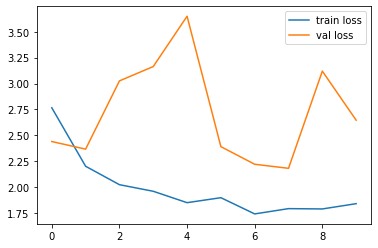

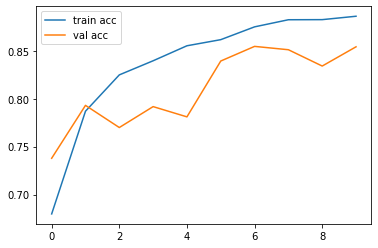

<Figure size 432x288 with 0 Axes>

In [21]:
# Plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# Plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

## Saving the model in h5 format

In [22]:
from tensorflow.keras.models import load_model
model.save('model_inception.h5')

In [23]:
y_pred = model.predict(test_set)

In [24]:
y_pred

array([[3.16511653e-25, 8.81288233e-18, 8.44172184e-30, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [6.33106965e-35, 9.07707211e-21, 7.97005401e-25, ...,
        0.00000000e+00, 1.76196410e-25, 4.90839858e-22],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       ...,
       [0.00000000e+00, 1.00000000e+00, 1.76769194e-24, ...,
        0.00000000e+00, 7.94723319e-35, 0.00000000e+00],
       [0.00000000e+00, 1.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 5.87722868e-27, 0.00000000e+00, ...,
        0.00000000e+00, 1.07079325e-33, 0.00000000e+00]], dtype=float32)

In [25]:
import numpy as np
y_pred = np.argmax(y_pred, axis=1)

In [26]:
y_pred

array([4, 6, 9, ..., 1, 1, 0])

In [42]:
import cv2

In [48]:
src = cv2.imread('/content/data/valid/Tomato___Leaf_Mold/0160c3b5-d89e-40e5-a313-49ae1524040a___Crnl_L.Mold 6823.JPG')
scale_percent = 50

width = int(224)
height = int(224)

dsize = (width, height)

output = cv2.resize(src, dsize)

cv2.imwrite('test2.jpg', output)

True

In [49]:
ls

AccVal_acc.png  kaggle.json       model_inception.h5  test2.jpg  tomato.zip
data/           LossVal_loss.png  sample_data/        test.jpg


In [50]:
img = image.load_img('test2.jpg')

In [51]:
x = image.img_to_array(img)
x

array([[[142., 126., 126.],
        [139., 123., 123.],
        [148., 132., 132.],
        ...,
        [184., 174., 173.],
        [186., 176., 175.],
        [184., 174., 173.]],

       [[158., 142., 142.],
        [154., 138., 138.],
        [156., 140., 140.],
        ...,
        [189., 179., 178.],
        [193., 183., 182.],
        [193., 183., 182.]],

       [[156., 140., 140.],
        [146., 130., 130.],
        [149., 133., 133.],
        ...,
        [187., 177., 176.],
        [187., 177., 176.],
        [185., 175., 174.]],

       ...,

       [[158., 142., 142.],
        [146., 130., 130.],
        [140., 124., 124.],
        ...,
        [183., 173., 172.],
        [178., 168., 167.],
        [187., 177., 176.]],

       [[147., 131., 131.],
        [140., 124., 124.],
        [140., 124., 124.],
        ...,
        [174., 164., 163.],
        [157., 147., 146.],
        [162., 152., 151.]],

       [[125., 109., 109.],
        [148., 132., 132.],
        [148., 1

In [52]:
x.shape

(224, 224, 3)

In [53]:
x=x/255

In [54]:
x = np.expand_dims(x, axis=0)
img_data = preprocess_input(x)
img_data.shape

(1, 224, 224, 3)

In [55]:
model.predict(img_data)

array([[5.0748439e-27, 2.1742180e-14, 1.0000000e+00, 7.9356606e-20,
        1.5946215e-08, 2.6112757e-15, 1.7446656e-18, 1.6961793e-21,
        3.2508907e-10, 3.7736811e-18]], dtype=float32)

In [56]:
a = np.argmax(model.predict(img_data), axis=1)

In [57]:
a

array([2])

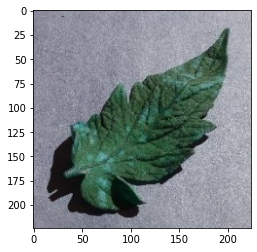

In [61]:
pict = cv2.imread('test2.jpg')
plt.imshow(pict)